# Demographics for alcoholic beverage entitlements

Let's take a close look at PCTS entitlements for serving of alcoholic beverages (CUB suffix)

In [1]:
import geopandas
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn.ensemble
import sklearn.inspection
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.utils

import laplan
import utils

cat = intake.open_catalog("../catalogs/*.yml")

## Prepping the data

First, download a bunch of relevant data into dataframes:

In [2]:
# Census tracts
tracts = cat.census_tracts.read().set_index("GEOID")
# Conversion from parcels to tracts
parcel_to_tract = cat.crosswalk_parcels_tracts.read()

We presume that CUB permits should only be in areas zoned for commercial use. Let's find all the parcels that fall within a commercial zoning area:

In [3]:
COMMERCIAL_ZONE_CLASSES = [
    "CR",
    "C1",
    "C1.5",
    "C2",
    "C4",
    "C5",
    "CM",
]
MANUFACTURING_ZONE_CLASSES = [
    "MR1",
    "MR2",
    "M1",
    "M2",
    "M3",
]
CUB_ZONE_CLASSES = COMMERCIAL_ZONE_CLASSES + MANUFACTURING_ZONE_CLASSES

zoning = (cat.crosswalk_tracts_zone_class.read()
          [["GEOID"] + CUB_ZONE_CLASSES]
         )

zoning = zoning.assign(
    pct_commercial = zoning[COMMERCIAL_ZONE_CLASSES].sum(axis=1),
    pct_manufacturing = zoning[MANUFACTURING_ZONE_CLASSES].sum(axis=1)
)

As an aggregate statistic, count the number of commercial parcels
on a per-census-tract level:

In [4]:
cub_eligible_tracts = (
    (parcel_to_tract[["GEOID", "total_AIN"]]
        .drop_duplicates()
      ).merge(
        zoning, 
        on = "GEOID",
        how = "left", 
        validate = "1:1"
    ).drop(columns = CUB_ZONE_CLASSES)
    .set_index("GEOID")
    )


cub_eligible_tracts = cub_eligible_tracts.assign(
    n_commercial = (round(cub_eligible_tracts.pct_commercial * cub_eligible_tracts.total_AIN, 0)
                    .fillna(0).astype(int)), 
    n_manufacturing = (round(cub_eligible_tracts.pct_manufacturing * cub_eligible_tracts.total_AIN, 0)
                       .fillna(0).astype(int))
).drop(columns = ["pct_commercial", "pct_manufacturing"])

Now, let's bring in Census data:

In [5]:
joined = utils.entitlements_per_tract(
    suffix_list=["CUB"],
    verbose=True,
    aggregate_years=True,
).fillna({"CUB": 0})

Loading PCTS
Parsing PCTS case numbers
6 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'ENV', 'PS', 'VTT', 'CHC', 'AA', 'TT', 'DIR', 'ADM', 'HPO'}
Loading census analysis table
Removing cases touching more than 20 parcels
Aggregating entitlements to tract
Joining entitlements to census data


Attach number of eligible parcels to the census + PCTS data:

In [6]:
joined = (joined.merge(
    cub_eligible_tracts,
    left_index = True,
    right_index = True,
    how = "left",
    validate = "1:1"
).assign(
    n_eligible=cub_eligible_tracts.n_commercial+cub_eligible_tracts.n_manufacturing,
).fillna({"n_eligible": 0})
         )

In [7]:
joined = geopandas.GeoDataFrame(joined, geometry=tracts.geometry)

## Where is commercial zoning?

<AxesSubplot:xlabel='Number of Eligible Parcels'>

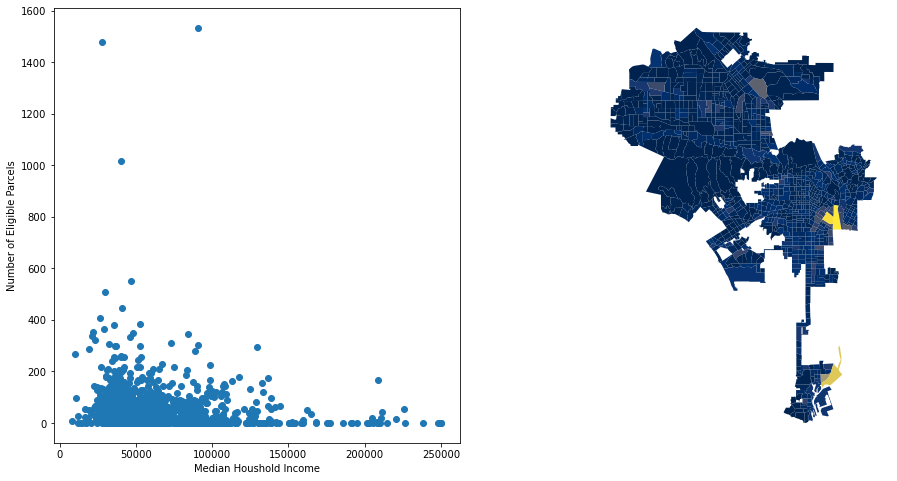

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(joined.medhhincome, joined.n_eligible)
ax[0].set_xlabel("Median Houshold Income")
ax[0].set_ylabel("Number of Eligible Parcels")
ax[1].set_xlabel("Number of Eligible Parcels")
ax[1].axis("off")
joined.plot(ax=ax[1], column="n_eligible", cmap="cividis")

## Modeling CUB entitlements

Let's use a Random Forest regressor as a baseline model for relating CUB permits to
demographic and zoning data. These models tend to do very well at fitting data and are simple to create.

In [9]:
variables = [
    "medhhincome",
    "pct_pop_renter",
    "pct_zero_veh_workers",
    "density",
    "pct_whitenonhisp",
    "n_eligible",
]
target = "CUB"

to_fit = joined.fillna(0.0)[variables + [target, "geometry"]]

Let's visualize the spatial distribution of these variables to check that they make sense:

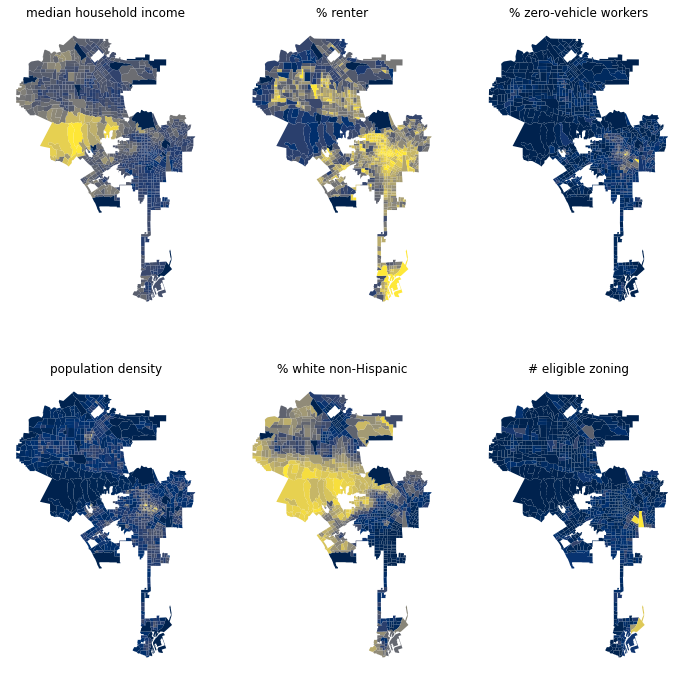

In [10]:
predictor_titles = {
    "medhhincome": "median household income",
    "pct_pop_renter": "% renter",
    "pct_zero_veh_workers": "% zero-vehicle workers",
    "density": "population density",
    "pct_whitenonhisp": "% white non-Hispanic",
    "n_eligible": "# eligible zoning",
}

fig, axes = plt.subplots(2, 3, figsize=(12,12))
for i, var in enumerate(variables):
    ax = axes.ravel()[i]
    to_fit.plot(ax=ax, column=var, cmap="cividis")
    ax.axis("off")
    ax.set_title(predictor_titles[var])
    
fig.savefig("../visualization/cub_regression_predictors_map.png", bbox_inches='tight')

In [11]:
# Set a max depth to avoid over-fitting
random_forest_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.ensemble.RandomForestRegressor(max_depth=8)),
])

In [12]:
def plot_model(predictions):
    vmin=0
    vmax=0.04
    cmap = "inferno"

    fig, axes = plt.subplots(1,2, figsize=(16, 16))
    axes[0].axis("off")
    axes[0].set_title("Actual CUB/parcel")
    (to_fit.assign(
        norm_CUB = to_fit.CUB / joined.total_AIN,
    ).fillna({"CUB": 0, "norm_CUB": 0})
     .plot(ax=axes[0],column="norm_CUB", vmax=vmax, vmin=vmin, cmap=cmap)
    )
    axes[1].axis("off")
    axes[1].set_title("Predicted CUB/parcel")
    (to_fit.assign(
        predictions=pandas.Series(predictions, index=to_fit.index),
        norm_pred=pandas.Series(predictions, index=to_fit.index).divide(joined.total_AIN),
    )
     .fillna({"predictions": 0, "norm_pred": 0})
     .plot(ax=axes[1],column="norm_pred", vmax=vmax, vmin=vmin, cmap=cmap)
    )
    plt.close(fig)
    return fig

Plot up the model to see how it does:

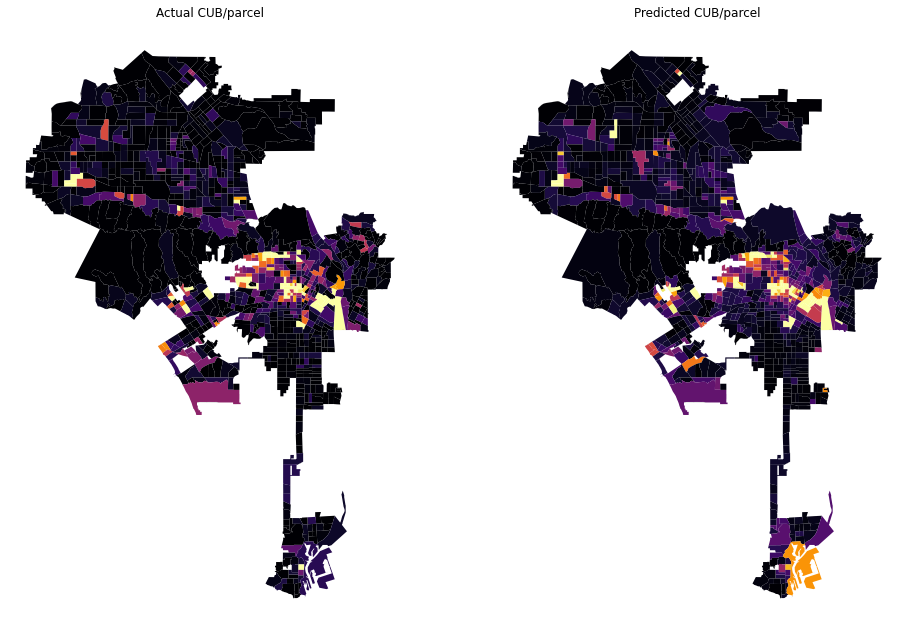

In [13]:
np.random.seed(1)

random_forest_model.fit(to_fit[variables], to_fit[target])

rf_plot = plot_model(random_forest_model.predict(to_fit[variables]))

rf_plot.savefig("../visualization/cub_regression_actual_predicted_randomforest_all.png", bbox_inches='tight')
rf_plot

Which of the features we have chosen are the most important in the random forest?

In [14]:
pandas.Series(random_forest_model["regressor"].feature_importances_, index=variables)

medhhincome             0.076524
pct_pop_renter          0.079773
pct_zero_veh_workers    0.107967
density                 0.118279
pct_whitenonhisp        0.183764
n_eligible              0.433692
dtype: float64

In [15]:
imp = sklearn.inspection.permutation_importance(
    random_forest_model,
    to_fit[variables],
    to_fit[target]
)
pandas.Series(imp["importances_mean"], index=variables)

medhhincome             0.082330
pct_pop_renter          0.093016
pct_zero_veh_workers    0.139164
density                 0.179443
pct_whitenonhisp        0.423037
n_eligible              0.965982
dtype: float64

Of our variables, the percentage of zero vehicle workers and the population density have the least explanatory power.
Let's drop them and see how the model performs.

In [16]:
np.random.seed(1)

fewer_variables= [
    "medhhincome",
    "pct_pop_renter",
    "pct_whitenonhisp",
    "n_eligible",
]
target = "CUB"

random_forest_model.fit(to_fit[fewer_variables], to_fit[target])
pandas.Series(random_forest_model["regressor"].feature_importances_, index=fewer_variables)

medhhincome         0.100139
pct_pop_renter      0.173058
pct_whitenonhisp    0.223625
n_eligible          0.503178
dtype: float64

In [17]:
imp = sklearn.inspection.permutation_importance(
    random_forest_model,
    to_fit[fewer_variables],
    to_fit[target]
)
pandas.Series(imp["importances_mean"], index=fewer_variables)

medhhincome         0.104562
pct_pop_renter      0.284826
pct_whitenonhisp    0.426720
n_eligible          0.940691
dtype: float64

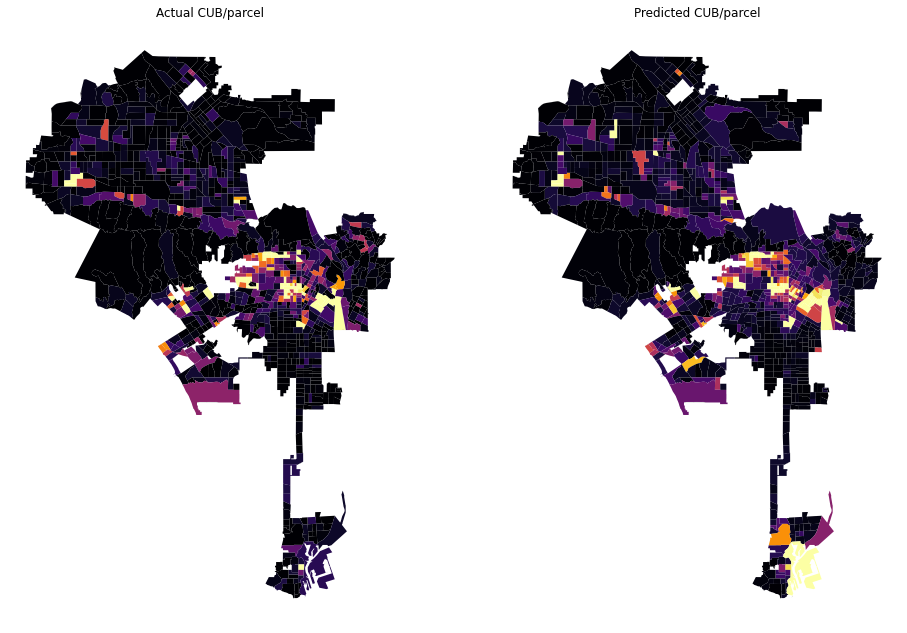

In [18]:
rf_plot_fewer = plot_model(random_forest_model.predict(to_fit[fewer_variables]))

rf_plot_fewer.savefig("../visualization/cub_regression_actual_predicted_randomforest_fewer.png", bbox_inches='tight')
rf_plot_fewer

Looks like it still does an acceptable job of predicing where the entitlements will be.
Unfortunately, random forest regression has a major drawback: it is difficult to interpret.
There is not a strong meaning we can attach to the decision tree splits,
and due to its ensemble nature, it is difficult to visualize.

We can instead try to fit the same data to a model with a strong backing process:
Poisson linear regression. In this model, the number of CUB entitlements are
modeled as a Poisson process, where the underlying rate is a log-linear function
of our features.


In [19]:
poisson_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, tol=1.e-6))
])

In [20]:
def sample_poisson_model(data, target, norm=1, seed=1): 
    def get_coefs(model):
        return model["regressor"].coef_
    rs = np.random.RandomState(seed)
    samples = np.array([
        get_coefs(
            poisson_model.fit(
                *sklearn.utils.resample(
                    data,
                    (target/norm).replace([np.nan, np.inf], 0.0),
                    random_state=rs,
                )
            )
        )
        for i in range(1000)
    ])
    return samples

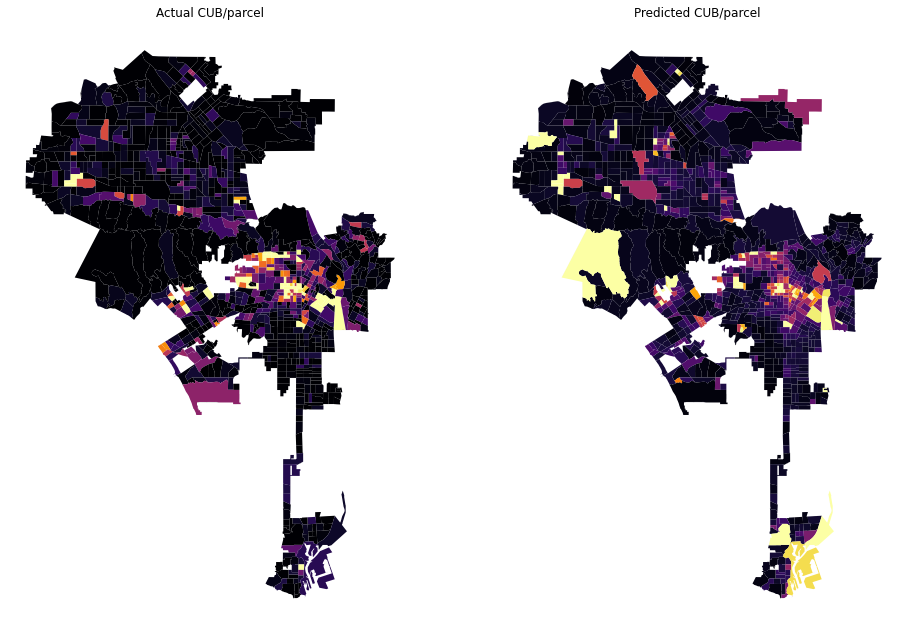

In [21]:
poisson_model.fit(to_fit[fewer_variables], to_fit[target])

poisson_plot = plot_model(poisson_model.predict(to_fit[fewer_variables]))

poisson_plot.savefig("../visualization/cub_regression_actual_predicted_poisson_fewer.png", bbox_inches='tight')
poisson_plot

In [22]:
imp = sklearn.inspection.permutation_importance(
    poisson_model,
    to_fit[fewer_variables],
    to_fit[target].astype("int64")
)
pandas.Series(imp["importances_mean"], index=fewer_variables)

medhhincome         0.015154
pct_pop_renter      0.220839
pct_whitenonhisp    0.075171
n_eligible          0.125348
dtype: float64

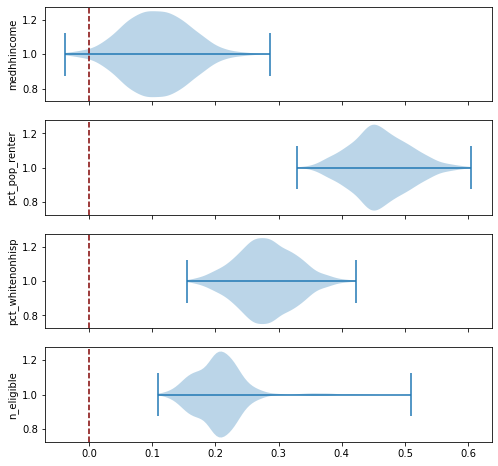

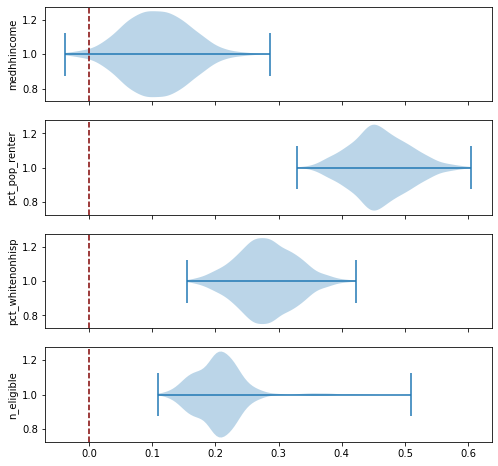

In [23]:
samples = sample_poisson_model(to_fit[fewer_variables], to_fit[target])

fig, axes = plt.subplots(
    len(fewer_variables),
    1,
    sharex=True,
    sharey=True,
    figsize=(8,8),

)

for i, var in enumerate(fewer_variables):
    ax = axes[i]
    ax.violinplot(samples[:,i], vert=False)
    ax.set_ylabel(var)
    ax.axvline(0, color="maroon", ls="--")

fig.savefig("../visualization/cub_regression_poisson_coeff.png", bbox_inches='tight')
fig

#### Interpreting the coefficients

In [24]:
scaler = poisson_model["scaler"]
regressor = poisson_model["regressor"]

In [25]:
beta = pandas.Series(regressor.coef_/scaler.scale_, index=fewer_variables)
alpha = regressor.intercept_ - np.dot(scaler.mean_ , beta)

In [26]:
import IPython.display

In [27]:
scale = 10000
val = (np.exp(beta[0]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every ${scale:,} increase in median household income, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))
scale = 0.1
val = (np.exp(beta[1]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of renters, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))
scale = 0.1
val = (np.exp(beta[2]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of white non-Hispanic residents, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))
scale = 10
val = (np.exp(beta[3]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {scale:g} additional eligible parcels, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))

For every $10,000 increase in median household income, there is a 4.6% increase in CUB entitlements

For every 10% increase in population of renters, there is a 20.4% increase in CUB entitlements

For every 10% increase in population of white non-Hispanic residents, there is a 7.1% increase in CUB entitlements

For every 10 additional eligible parcels, there is a 1.9% increase in CUB entitlements